## Bagging

In [3]:
import pandas as pd
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

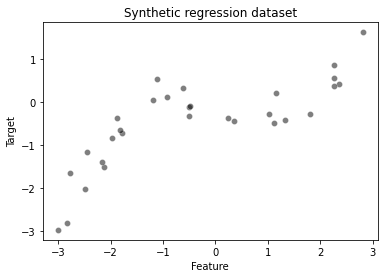

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [5]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

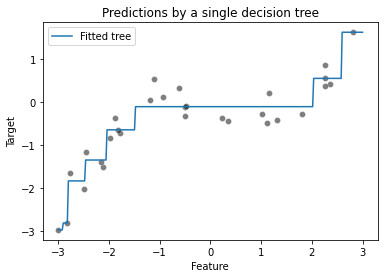

In [6]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test, y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

## Bootstrap resampling

In [7]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

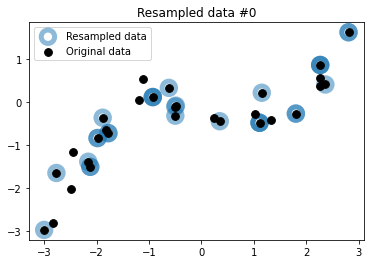

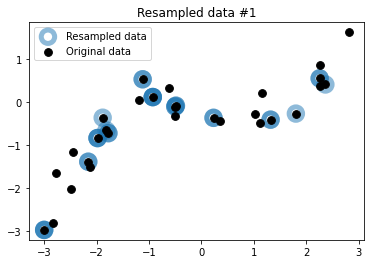

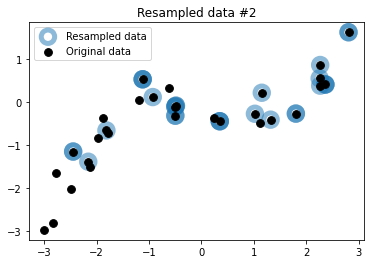

In [8]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_bootstrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

In [9]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


In [11]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    
    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

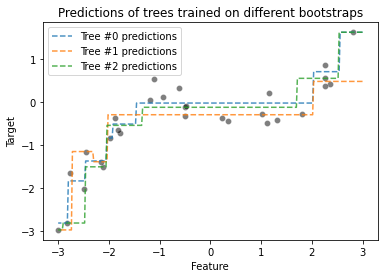

In [12]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

## Aggregating

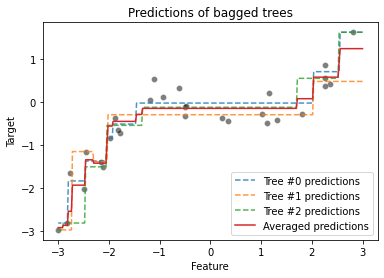

In [13]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test, bag_predictions, label="Averaged predictions",
         linestyle="-")
plt.legend()
_ = plt.title("Predictions of bagged trees")

## Bagging in scikit-learn

In [14]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

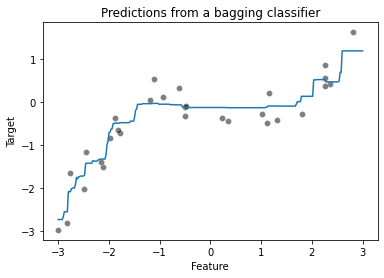

In [15]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

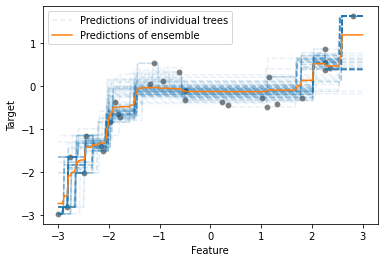

In [17]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)
    
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

## Bagging complex pipelines

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

In [19]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

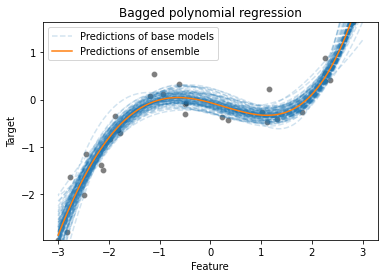

In [20]:
for i, regressor in enumerate(bagging.estimators_):
    regressor_predictions = regressor.predict(data_test)
    base_model_line = plt.plot(
        data_test, regressor_predictions, linestyle="--", alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue")
    
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
bagging_predictions = bagging.predict(data_test)
plt.plot(data_test, bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")    


The predictions of this bagged polynomial regression model looks
qualitatively better than the bagged trees. This is somewhat expected since
the base model better reflects our knowldege of the true data generating
process.

Again the different shades induced by the overlapping blue lines let us
appreciate the uncertainty in the prediction of the bagged ensemble.

To conclude this notebook, we note that the bootstrapping procedure is a
generic tool of statistics and is not limited to build ensemble of machine
learning models. The interested reader can learn more on the [Wikipedia
article on
bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).